# Malware Detection Model Training

This notebook trains and compares different machine learning models (Random Forest, LightGBM, XGBoost) for malware detection using the extracted features.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting style
sns.set_style('whitegrid')
plt.style.use('default')

In [3]:
def load_and_preprocess_data(train_path, test_path=None, scale_features=True):
    """Load and preprocess the data for model training"""
    # Load training data
    train_df = pd.read_csv(train_path)
    
    # Separate features and labels
    X = train_df.drop('label', axis=1)
    y = train_df['label']
    
    # Scale features if requested
    if scale_features:
        scaler = StandardScaler()
        X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    
    # Load test data if provided
    X_test = None
    y_test = None
    if test_path:
        test_df = pd.read_csv(test_path)
        X_test = test_df.drop('label', axis=1)
        y_test = test_df['label']
        if scale_features:
            X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    
    return X, y, X_test, y_test

def plot_feature_importance(model, feature_names, title='Feature Importance'):
    """Plot feature importance for the given model"""
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    else:
        return
    
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(12, 6))
    plt.title(title)
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def plot_roc_curves(models, X_val, y_val):
    """Plot ROC curves for multiple models"""
    plt.figure(figsize=(10, 8))
    
    for name, model in models.items():
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc='lower right')
    plt.show()

In [4]:
# Load the extracted features
print("Loading and preprocessing data...")
X, y, _, _ = load_and_preprocess_data('malware_detection_features.csv')

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\nDataset shapes:")
print(f"Training: {X_train.shape}")
print(f"Validation: {X_val.shape}")

Loading and preprocessing data...

Dataset shapes:
Training: (8000, 10)
Validation: (2000, 10)


## 1. Random Forest Model

Training Random Forest...

Best parameters:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1000
           1       0.93      0.91      0.92      1000

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000


Best parameters:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1000
           1       0.93      0.91      0.92      1000

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000



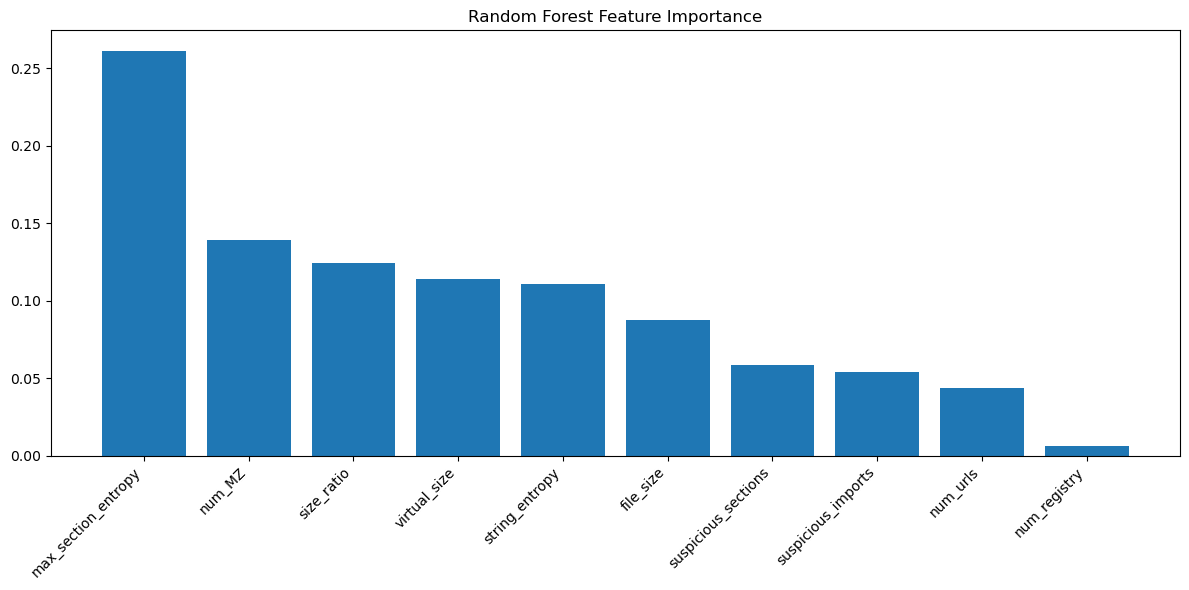

In [5]:
# Train Random Forest
print("Training Random Forest...")
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_grid = GridSearchCV(rf, rf_params, cv=3, scoring='roc_auc', n_jobs=-1)
rf_grid.fit(X_train, y_train)

print("\nBest parameters:")
print(rf_grid.best_params_)

rf_best = rf_grid.best_estimator_
y_pred_rf = rf_best.predict(X_val)

print("\nRandom Forest Performance:")
print(classification_report(y_val, y_pred_rf))

# Plot feature importance
plot_feature_importance(rf_best, X.columns, 'Random Forest Feature Importance')

## 2. LightGBM Model

Training LightGBM...
[LightGBM] [Info] Number of positive: 4000, number of negative: 4000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1569
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 4000, number of negative: 4000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1569
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Best parameters:
{'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 127}

LightGBM

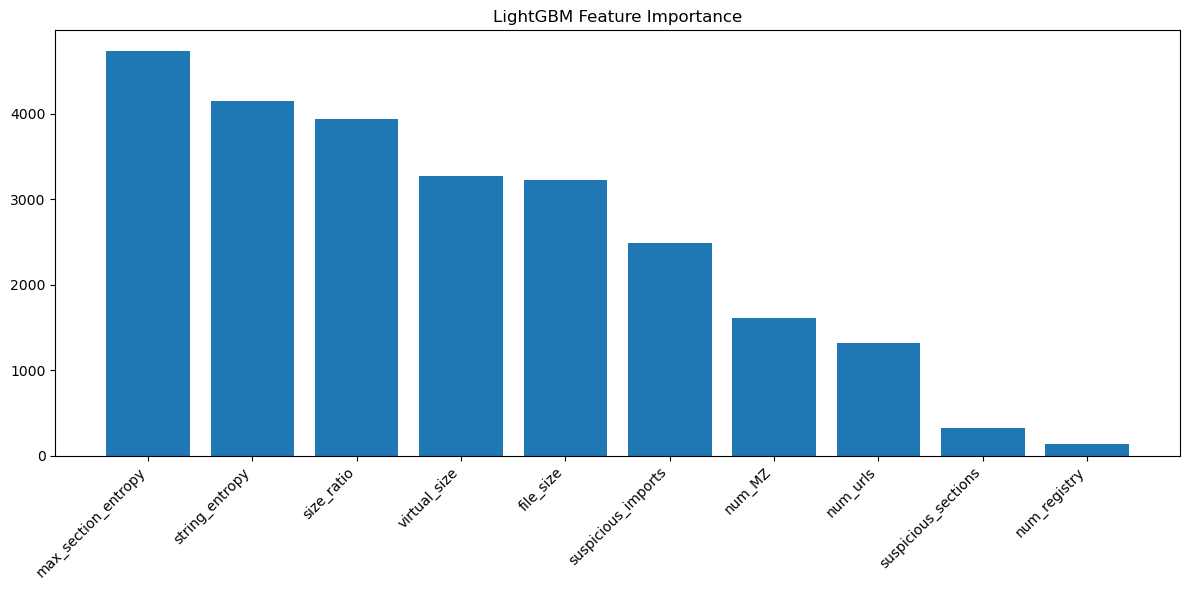

In [6]:
# Train LightGBM
print("Training LightGBM...")
lgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [-1, 10, 20],
    'num_leaves': [31, 63, 127],
    'learning_rate': [0.01, 0.1]
}

lgb_model = lgb.LGBMClassifier(random_state=42, n_jobs=-1)
lgb_grid = GridSearchCV(lgb_model, lgb_params, cv=3, scoring='roc_auc', n_jobs=-1)
lgb_grid.fit(X_train, y_train)

print("\nBest parameters:")
print(lgb_grid.best_params_)

lgb_best = lgb_grid.best_estimator_
y_pred_lgb = lgb_best.predict(X_val)

print("\nLightGBM Performance:")
print(classification_report(y_val, y_pred_lgb))

# Plot feature importance
plot_feature_importance(lgb_best, X.columns, 'LightGBM Feature Importance')

## 3. XGBoost Model

Training XGBoost...

Best parameters:
{'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200}

XGBoost Performance:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1000
           1       0.92      0.91      0.92      1000

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000


Best parameters:
{'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200}

XGBoost Performance:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1000
           1       0.92      0.91      0.92      1000

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000



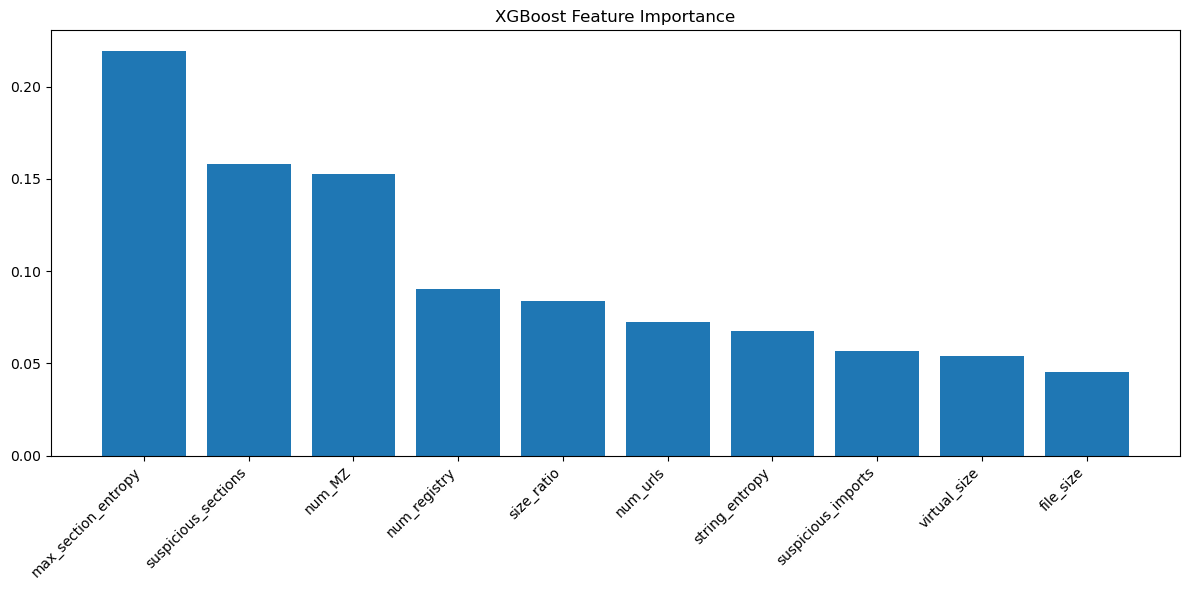

In [7]:
# Train XGBoost
print("Training XGBoost...")
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1],
    'min_child_weight': [1, 3]
}

xgb_model = xgb.XGBClassifier(random_state=42, n_jobs=-1)
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=3, scoring='roc_auc', n_jobs=-1)
xgb_grid.fit(X_train, y_train)

print("\nBest parameters:")
print(xgb_grid.best_params_)

xgb_best = xgb_grid.best_estimator_
y_pred_xgb = xgb_best.predict(X_val)

print("\nXGBoost Performance:")
print(classification_report(y_val, y_pred_xgb))

# Plot feature importance
plot_feature_importance(xgb_best, X.columns, 'XGBoost Feature Importance')

## Model Comparison

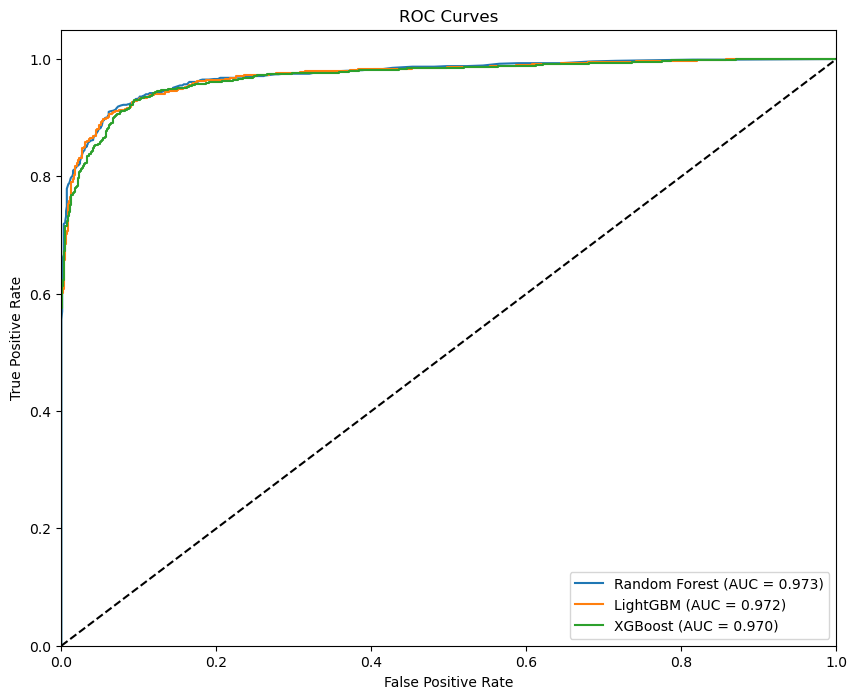


Model Comparison:
           Model  Accuracy   AUC-ROC
0  Random Forest    0.9225  0.973391
1       LightGBM    0.9180  0.971863
2        XGBoost    0.9160  0.969703


: 

In [ ]:
# Compare models using ROC curves
models = {
    'Random Forest': rf_best,
    'LightGBM': lgb_best,
    'XGBoost': xgb_best
}

plot_roc_curves(models, X_val, y_val)

# Compare model performance metrics
results = []
for name, model in models.items():
    # Get predictions
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    
    # Calculate metrics
    accuracy = (y_pred == y_val).mean()
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
    auc_score = auc(fpr, tpr)
    
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'AUC-ROC': auc_score
    })

results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df)